# Task 4 of QOSF

Find the lowest eigenvalue of the following matrix:

\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & -1& 0\\
0 & -1& 0 & 0\\
0 & 0 & 0& 1\\
\end{pmatrix}

using VQE-like circuits.


### Lowest Eigenvalue of the matrix in Ideal conditions

To find out what the exact ground state energy is, we find the minimum of the eigenvalues in ideal conditions.To find out the eigenvalues for our matrix H, we will use the numpy.linalg.eigvals function. For finding the lowest eigenvalue, we invoke the .min function

In [1]:
%matplotlib inline
from qiskit import *
import math
import numpy as np
from numpy import kron
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt

In [2]:
H=np.mat("1 0 0 0;0 0 -1 0;0 -1 0 0;0 0 0 1")

In [3]:
print("The eigenvalues of the Hamiltonian are: ", np.linalg.eigvals(H))
print('The exact ground state energy is: ', min(np.linalg.eigvals(H)))

The eigenvalues of the Hamiltonian are:  [ 1. -1.  1.  1.]
The exact ground state energy is:  -1.0


# VQE algorithm for a 2-qubit system

The first step for applying the VQE algorithm is to decompose the 4x4 matrix above and write it as a linear combination of tensor products of Pauli Matrices. This is because the Pauli Matrices form the basis for any 2x2 hermitian matrix, and tensor products of the pauli matrices can form a basis for the 2 qubit system. Then we can compute the expectation value $\hspace{2pt}$$\left\langle H \right\rangle$ of the hamiltonian by adding the expectation values of its parts (Pauli terms). The four pauli matrices are:
$$ I \equiv \sigma_0 = \biggl(\begin{array} \ 1 & 0 \\ 0 & 1 \end{array}\biggr) ,\quad \sigma_x = \biggl(\begin{array} \ 0 & 1 \\ 1 & 0 \end{array}\biggr) ,\quad \sigma_y = \biggl(\begin{array} \ 0 & -i \\ i & 0 \end{array}\biggr) ,\quad \sigma_z = \biggl(\begin{array} \ 1 & 0 \\ 0 & -1 \end{array}\biggr) \tag{1} $$

In [4]:
PauliI = np.array([[1, 0],
                  [0, 1]])

PauliX = np.array([[0, 1],
                   [1, 0]])

PauliY = np.array([[0,-1j],
                   [1j, 0]])

PauliZ = np.array([[1, 0],
                   [0,-1]])


For calculating the Pauli Matrix decomposition, the following formula is applied

$$H= \sum_{i,j=1, x,y,z} a_{i,j}(\sigma_i\otimes\sigma_j) , \hspace{20pt}      a_{i,j}= \frac {1} {4} {[(\sigma_i\otimes\sigma_j)]}\hspace {4pt} H $$
The factor of $ \frac {1}{4}$ is to normalize the pauli matrices as $\| \sigma_i\|$ =  $\sqrt{\mathrm {tr}\hspace {2pt}(\sigma_i^\dagger\sigma_i)}=\sqrt{2}$


##### We will first use the Hilbert-Schmidt Product of two matrices, say X and Y

In [5]:
def HS(X,Y):
    return(np.dot(X.conjugate().transpose(), Y)).trace()

Next we will find a function to decompose a 4x4 matrix into the sum of Pauli terms

In [6]:
def decompose(H):
   
    PauliI = np.array([[1,0],[0,1]], dtype=np.complex128)
    PauliX = np.array([[0,1],[1,0]], dtype=np.complex128)
    PauliY = np.array([[0,-1j],[1j,0]], dtype=np.complex128)
    PauliZ = np.array([[1,0],[0,-1]], dtype=np.complex128)
    PauliMat = [PauliI,PauliX,PauliY,PauliZ]
    labels = ['I','𝜎_x','𝜎_y','𝜎_z']
    x="*"
    for i in range(4):
        for j in range(4):
            label=labels[i]+'⊗'+ labels[j]
            a_ij=0.25*HS(kron(PauliMat[i],PauliMat[j]),H)
            if a_ij!=0.0:
                print(' {}  {}  {}'  .format (a_ij,"*",label))
                

In [7]:
decompose(H)

 [[0.5+0.j]]  *  I⊗I
 [[-0.5+0.j]]  *  𝜎_x⊗𝜎_x
 [[-0.5+0.j]]  *  𝜎_y⊗𝜎_y
 [[0.5+0.j]]  *  𝜎_z⊗𝜎_z



Therefore the hamiltonian can be expressed as $0.5 \cdot I\otimes I$  $-0.5 \cdot \sigma_x\otimes\sigma_x$  $ -0.5\cdot \sigma_y\otimes\sigma_y$+ $0.5 \cdot \sigma_z\otimes\sigma_z$
                                            

#### The next step is to prepare the quantum state $|\psi(\mathrm{vec\hspace{1pt}\theta}) \rangle$, or the ansatz which is a guess in finding approximations to the  eigenstate corresponding to the lowest value eigenvalue in the variational method.

$$ \mathrm{Find \hspace{2pt} a\hspace{2pt} \psi \hspace{2pt}such\hspace{2pt} that \hspace{2pt}its \hspace{2pt}expectation\hspace{2pt}value}\min_\theta\left\langle \psi(\mathrm{vec\hspace{1pt}\theta}) \right| H \left| \psi(\mathrm{vec\hspace{1pt}\theta}) \right\rangle $$

In [22]:
def ansatz_initialization(circuit,theta):
    q = circuit.qregs[0]
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.rx(theta,q[0])
    return circuit
   

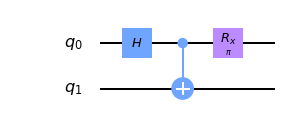

In [23]:
qc=QuantumCircuit(2)         #example of what the ansatz looks like
qc1=ansatz_initialization(qc,np.pi)
qc1.draw(output = 'mpl')

#### Measuring expectation values in the different basis (ZZ, XX, YY, II) on a qasm simulator(noiseless)

We will first measure the expectation value in z-basis. This is because when we call .measure_all(), by default in qiskit, the measurement happens along the $|0\rangle$ and$|1\rangle$ basis. We will first define the functions for measuring along ZZ,YY,XX

In [24]:
def zz_measure(theta):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    circuit = ansatz_initialization(circuit,theta)
    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])
    return circuit

For taking measurement along Y basis, we have to write Y basis in terms of Z basis. We have to find a matrix which we will call the $Y_{gate}$ to go from $|+i\rangle\hspace{2pt},|-i\rangle$ to$\hspace{2pt}$$|0\rangle\hspace{2pt},|1\rangle$ basis. The matrix we find is $$Y_{gate} = \frac{1}{\sqrt{2}}\begin{pmatrix}\\
    1 & -i\\\\\,
     1 & i
    \end{pmatrix}$$.

In order to write the $Y_{gate}$ in terms of an in-built gate in qiskit, we consider the following gate
$$ U2(\phi,\lambda)=\frac{1}{\sqrt2}\begin{pmatrix}\\
1 &-e^{i \lambda}\\\\\,
e^{i\phi}&e^{i(\phi+\lambda)}
\end{pmatrix}$$$\\\\$If we consider $\phi$=0 and $\lambda$=$\frac{\pi}{2}$ then we get the Y_gate


#### Note:An alternative way is to append  rotations RY(−π/2) to the X basis or RX(π/2) to the Y basis to enable measurement of expectation value of XX or YY in the computational basis as  we can switch between |+$\rangle$, |-$\rangle$ to $|0\rangle$ $|1\rangle$ by performing a rotation around the Y or X axis by 90 degrees

In [25]:
from qiskit.circuit.library import U2Gate
Y_gate = U2Gate(0, np.pi/2).to_matrix()
def yy_measure(theta):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    circuit = ansatz_initialization(circuit,theta)
    circuit.u2(0, np.pi/2, q[0])
    circuit.u2(0, np.pi/2, q[1])
    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])
    
    return circuit

For taking measurement along X basis, we have to find a matrix that will go from the $|+\rangle$$\hspace{2pt},|-\rangle\hspace{2pt}$ to the $|0\rangle\hspace{2pt},|1\rangle$ basis.
The matrix we find is $$\frac{1}{\sqrt{2}}\begin{pmatrix}\\1&1\\\\1&-1\end{pmatrix}$$
This is the hadamard gate or $H_{gate}$. The $H_{gate}$ can be expressed as U2(0,$\pi$)

Measurement in the XX basis


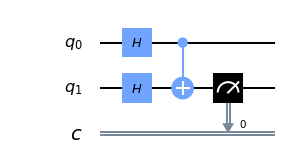

In [26]:
qc = QuantumCircuit(2,1)

qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the XX basis")
qc.draw(output="mpl")

In [27]:
H_gate = U2Gate(0, np.pi).to_matrix()
def xx_measure(theta):
    q=QuantumRegister(2)
    c=ClassicalRegister(2)
    circuit=QuantumCircuit(q,c)
    circuit=ansatz_initialization(circuit,theta)
    circuit.u2(0,np.pi,q[0])
    circuit.u2(0,np.pi,q[1])
    circuit.measure(q[0],c[0])
    circuit.measure(q[1],c[1])
    return circuit

#### We will now calculate the expectation value of the hamiltonian, measured in the Z basis

We know that in order to calculate the expectation value for a 1-qubit hamiltonian, the formula is

$$\left\langle H \right\rangle = \left\langle \psi \right| H \left| \psi \right\rangle = a \cdot \left\langle \psi \right| I \left| \psi \right\rangle + b \cdot \left\langle \psi \right| Z \left| \psi \right\rangle + c \cdot \left\langle \psi \right| X \left| \psi \right\rangle + d \cdot \left\langle \psi \right| Y \left| \psi \right\rangle.$$
 $$\\\\\\\\\\\\$$for Pauli_I operator the expectation value is always unity: $\left\langle \psi \right| I \left| \psi \right\rangle = \left\langle \psi \right| \left| \psi \right\rangle = 1$
$$\\\\$$We will look at the expectation values for the Z Pauli operator in the 1-qubit case


$$\left\langle \psi \right| Z \left| \psi \right\rangle  = \left( {c_1^z}^* \cdot \left\langle 0 \right| + {c_2^z}^* \cdot \left\langle 1 \right| \right) X \left( c_1^z \cdot \left| 0 \right\rangle +{c_2^z}\cdot \left| 1 \right\rangle \right) = {\left| c_1^z \right|}^2 - {\left| c_2^z \right|}^2$$

$$\\\\$$The probability of finding the qubit after measurement in $\left| 0 \right\rangle$ state= $|c_{1}^{z}|^2$ will be equal to $\frac{n_0}{N}$, where $n_0$ is the number of the $\left| 0 \right\rangle$ state measurments. The probability of finding the qubit after measurement in $\left |1\right\rangle$=$|c_{2}^{z}|^2$ is equal to,  $\frac{n_1}{N}$, where $n_1$ is the number of the $\left| 1 \right\rangle$ state measurments. Resultant expectation value will be $\left\langle Z \right\rangle = \frac{n_0 - n_1}{N}$
    For the 2 qubit case, there are 4 possibilities for qubit 0 and qubit 1 state after measurement: 00, 01, 10, 11
$$\\\\\\\\$$
$$\langle H\rangle\hspace{2pt}=\hspace{2pt}\frac{1}{N}.(n_{00}\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle +n_{01}\left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle)+n_{10}\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle\hspace{1pt}+n_{11}\left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle$$
$$\\\\\\\\$$
$n_{00}$ indicates the number of $\left|0 0\right\rangle$ measurements,$n_{01}$ indicates the number of $\left|0 1\right\rangle$ measurements, $n_{10}$ indicates the number of $\left|10\right\rangle$ measurements,$n_{11}$ indicates the number of $\left|11\right\rangle$ measurements.
Also,$\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle = \left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle = 1$ and$\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle = \left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle = -1$ 
$$\\\\\\$$
We can simplify the expectation value as:$$\frac{1}{N}.((n_{00} + n_{11}) - (n_{10} + n_{01}))$$

For measuring the expectation value in the X and Y basis, we have to apply the $H_{gate}$ and $Y_{gate}$ operator respectively 
$$H_{gate} \left| \psi \right\rangle = H_{gate} \left( c_1^x \cdot \left| + \right\rangle + c_2^x \cdot \left| - \right\rangle \right) = c_1^x \cdot \left| 0 \right\rangle + c_2^x \cdot \left| 1 \right\rangle,$$

where $H_{gate}$ is an operator such that $H_{gate} \left| + \right\rangle = \left| 0 \right\rangle$ and $H_{gate} \left| - \right\rangle = \left| 1 \right\rangle$



$$Y_{gate} \left| \psi \right\rangle = Y_{gate} \left( c_1^y \cdot \left| +i \right\rangle + c_2^y \cdot \left| -i \right\rangle \right) = c_1^y \cdot \left| 0 \right\rangle + c_2^y \cdot \left| 1 \right\rangle,$$



where $Y_{gate}$ is an operator such that $Y_{gate} \left| +i \right\rangle = \left| 0 \right\rangle$ and $Y_{gate} \left| -i \right\rangle = \left| 1 \right\rangle$.

$$$$For measuring the expectation value in X basis we can write,

$$H_{gate} \otimes H_{gate} \left| \psi \right\rangle = H_{gate} \otimes H_{gate} \left( c_1^{XX}\left| ++ \right\rangle + c_2^{XX}\left| +- \right\rangle + c_3^{XX}\left| -+ \right\rangle + c_4^{XX}\left| -- \right\rangle \right) \\
$$$$= c_1^{XX}\left| 00 \right\rangle + c_2^{XX}\left| 01 \right\rangle + c_3^{XX}\left| 10 \right\rangle + c_4^{XX}\left| 11 \right\rangle,$$
$$$$where $\left| c \right|^2$ are probabilities of obtaining the corresponding eigenvectors of $XX$ after the measurement

In [29]:
def expectationvalue_zz(theta):

    circuit=zz_measure(theta)
    shots = 1024
    backend = BasicAer.get_backend('qasm_simulator')
   
    job = execute(circuit, backend,shots=shots)
    result = job.result()
    counts = result.get_counts()
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['10']
    expectation_value = expectation_value / shots

    return expectation_value

def expectationvalue_yy(theta):
    circuit=yy_measure(theta)
    shots = 1024
   
    backend = BasicAer.get_backend('qasm_simulator')
    
    job = execute(circuit, backend,shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['01']
    expectation_value = expectation_value / shots

    return expectation_value
  

def expectationvalue_xx(theta):
    circuit=xx_measure(theta)
    shots = 1024
    backend = BasicAer.get_backend('qasm_simulator')
   
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['01']
    expectation_value = expectation_value / shots

    return expectation_value
    

Since the expectation value of the hamiltonian is the sum of expectation value of its Pauli Terms,
$$\left\langle H \right\rangle = a \cdot \left\langle \psi \right| II \left| \psi \right\rangle + b \cdot \left\langle \psi \right| XX \left| \psi \right\rangle + c \cdot \left\langle \psi \right| ZZ \left| \psi \right\rangle + d \cdot \left\langle \psi \right| YY \left| \psi \right\rangle.$$

#### Next we will use a classical non-linear optimizer to minimize the expectation value by varying ansatz parameters vec(θ)

We have to  calculate the expectation value of $H$, over many trial wavefunctions with the objective to get the wavefunction with minimum expectation value. $min_\theta\left\langle \psi\hspace{2pt}(\mathrm (vec\theta) \right| H \left| \psi\hspace{2pt} \mathrm (vec \theta)\right\rangle$
We are going to use a classical optimizer from scipy.optimize, which returns the optimal angle $\theta$ and the wavefunction $\left| \psi\mathrm(vec\theta) \right\rangle$ corresponding to minimum expectation value.

In [30]:
def get_expectationvalue(theta):
    
    zz = expectationvalue_zz(theta)
    xx = expectationvalue_xx(theta)
    yy = expectationvalue_yy(theta)
    
    resultant_value = 0.5*1 + (-0.5)*xx + (-0.5)*yy + 0.5*zz #taking the coefficients obtained from decomposition into tensor product of Pauli Matrices
       
    return resultant_value

We can iterate over the parameter $\theta$ to create a graph of how the expectation value varies with $\theta$

In [46]:
angle = np.linspace(0, 2*np.pi)

lowest_values=[]
for i in angle:
    val = get_expectationvalue(i)
    lowest_values.append(val)
    lowest_array = np.array(lowest_values)

In [39]:
angle=0#initialize an arbitary angle 

result = minimize(get_expectationvalue,angle, method="COBYLA", tol=10**-5)


print('minimum eigenvalue obtained from noisless simulator is: {}'.format(result.fun))
print("\nThe optimal angle is : {} ".format(result.x))

minimum eigenvalue obtained from noisless simulator is: -0.99658203125

The optimal angle is : 3.18358375 


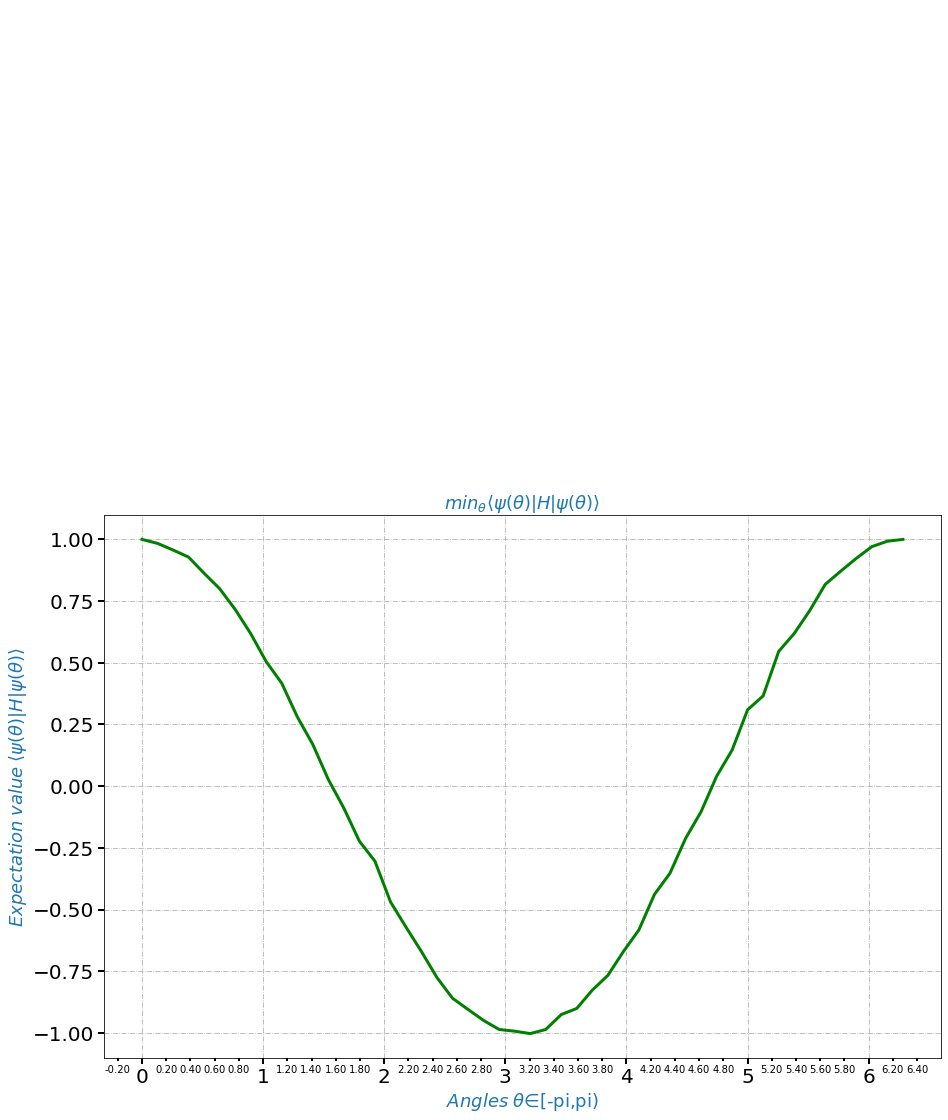

The lowest eigenvalue returned by simulator is:  -1.0012448382560264


In [47]:

from matplotlib.ticker import *

figure = plt.figure(figsize=(15,10))
subplot= figure.add_subplot()
subplot.plot(angle, lowest_array, linewidth=3, color='green')

subplot.annotate('The minimum eigenvalue', xy=(-1.01171875,3.1259865625), xytext=(-1.01171875, 3.1259865625 ),
             arrowprops=dict(facecolor='black', shrink=0.05),)
def pointer(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x
subplot.xaxis.set_minor_locator(AutoMinorLocator()) 
subplot.xaxis.set_minor_formatter(FuncFormatter(pointer)) 
subplot.tick_params(which='both', width=2) 
subplot.tick_params(which='major', length=6)
subplot.tick_params(which='minor', length=3, color='black') 
subplot.tick_params(labelcolor='black', labelsize=20, width=2) 

plt.xlabel(r'$Angles \; \theta ∈ [$-pi,pi$)$', {'color': 'C0', 'fontsize': 18})
plt.ylabel(r'$Expectation \; value \; \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.title(r'$min_\theta \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.grid(linestyle='-.')
plt.show()
inter = np.interp( result.x ,angle,lowest_array)
print('The lowest eigenvalue returned by simulator is: ',inter)

## Effect of Noise on VQE

In [48]:

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
import qiskit.tools.jupyter


The Qiskit Aer noise module is used to generate noise on an IBMQ device, as we are in NISQ and due to errors caused by:

Whenever a gate is applied, there’s  chance (e.g. 0.1%) that a different gate will be applied.

Short decoherence times

Limited number of qubits.

We can expect that when we run the VQE on simulator with noise,minimum eigenvalue will be slightly greater.

I will use ibmq_vigo device. The coupling map should also be obtained when compiling the circuit to closely resemble the result obtained on a real device.

In [49]:
provider = IBMQ.load_account()
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [50]:
device_backend = provider.get_backend('ibmq_vigo')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates
from qiskit import IBMQ, Aer,execute

In [51]:
def expectationvalue_zznoise(theta,noise_model,coupling_map,basis_gates):

    circuit=zz_measure(theta)
    shots = 1024
    backend =Aer.get_backend('qasm_simulator')
   
    job = execute(circuit, backend,coupling_map=coupling_map,shots=shots,basis_gates=basis_gates,noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['10']
    expectation_value = expectation_value / shots

    return expectation_value

def expectationvalue_yynoise(theta,noise_model,coupling_map,basis_gates):
    circuit=yy_measure(theta)
    shots = 1024
   
    backend = Aer.get_backend('qasm_simulator')
    
    job1 = execute(circuit, backend,noise_model=noise_model,coupling_map=coupling_map,shots=shots,basis_gates=basis_gates)
    result1 = job1.result()
    counts = result1.get_counts()
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['01']
    expectation_value = expectation_value / shots

    return expectation_value
  

def expectationvalue_xxnoise(theta,noise_model,coupling_map,basis_gates):
    circuit=xx_measure(theta)
    shots = 1024
    backend = Aer.get_backend('qasm_simulator')
   
    job = execute(circuit, backend,noise_model=noise_model,coupling_map=coupling_map,shots=shots,basis_gates=basis_gates)
    result = job.result()
    counts = result.get_counts()
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    total = counts['00'] + counts['01'] + counts['10'] + counts['11']
    expectation_value= counts['00'] + counts['11'] - counts['10'] - counts['01']
    expectation_value = expectation_value / shots

    return expectation_value
    

In [53]:
def get_expectationvaluenoise(theta):
    noise_model = NoiseModel.from_backend(device_backend)
    coupling_map = device_backend.configuration().coupling_map
    basis_gates = noise_model.basis_gates
    zz = expectationvalue_zznoise(theta,noise_model,coupling_map,basis_gates)
    xx = expectationvalue_xxnoise(theta,noise_model,coupling_map,basis_gates)
    yy = expectationvalue_yynoise(theta,noise_model,coupling_map,basis_gates)
    
    resultant_value = 0.5*1 + (-0.5)*xx + (-0.5)*yy + 0.5*zz #taking the coefficients obtained from decomposition into tensor product of Pauli Matrices
       
    return resultant_value

In [55]:
angle=0#initialize an arbitary angle 

result1 = minimize(get_expectationvaluenoise,angle, method="COBYLA", tol=10**-5)


print('minimum eigenvalue obtained from noisless simulator is: {}'.format(result1.fun))
print("\nThe optimal angle is : {} ".format(result1.x))

minimum eigenvalue obtained from noisless simulator is: -0.90966796875

The optimal angle is : 3.1259865625 


In [57]:
angle = np.linspace(0, 2*np.pi)

lowest_values=[]
for i in angle:
    val = get_expectationvaluenoise(i)
    lowest_values.append(val)
    lowest_array = np.array(lowest_values)

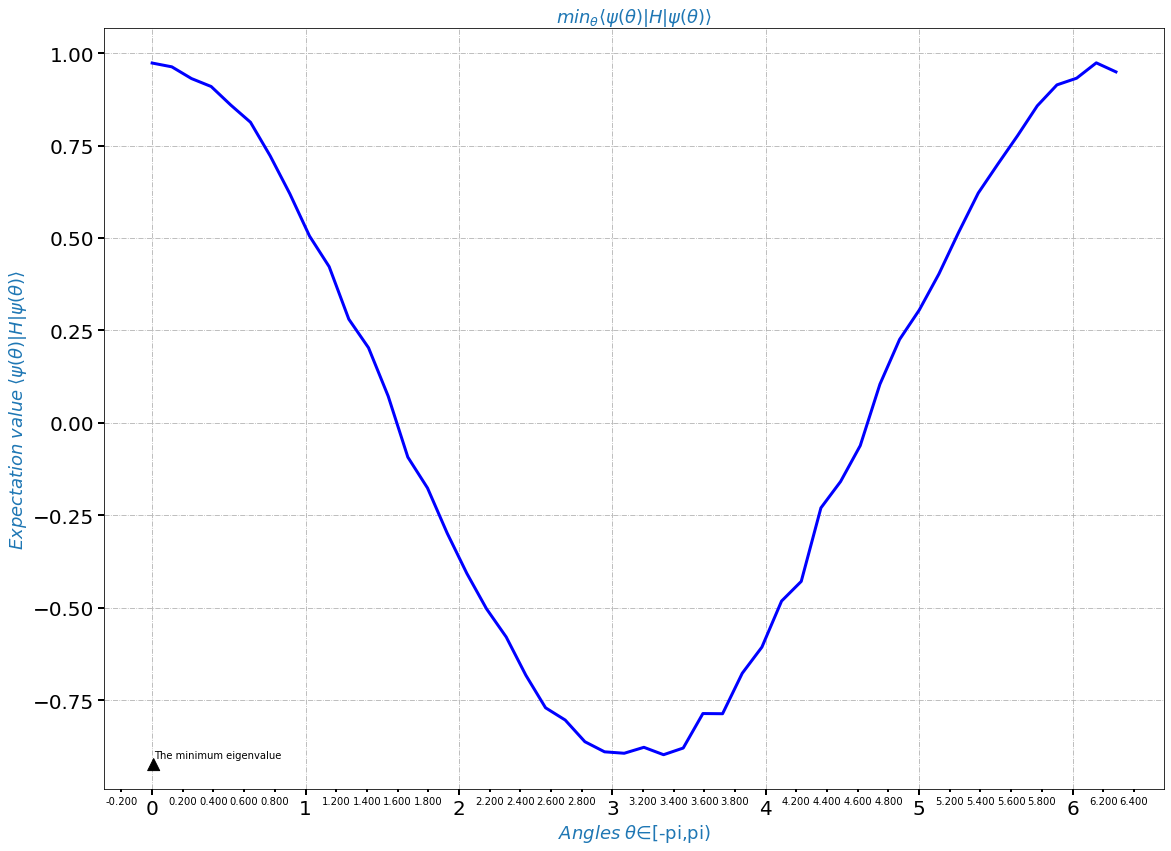

The lowest eigenvalue returned by simulator is:  -0.8802214075025564


In [59]:
from matplotlib.ticker import *

figure = plt.figure(figsize=(19,14))
subplot= figure.add_subplot()
subplot.plot(angle, lowest_array, linewidth=3, color='blue')

subplot.annotate('The minimum eigenvalue', xy=(0.01,-0.907714), xytext=(0.01, -0.907714),
             arrowprops=dict(facecolor='black', shrink=0.05),)
def pointer(x, pos):
    if not x % 1.0:
        return ""
    return "%.3f" % x
subplot.xaxis.set_minor_locator(AutoMinorLocator()) 
subplot.xaxis.set_minor_formatter(FuncFormatter(pointer)) 
subplot.tick_params(which='both', width=2) 
subplot.tick_params(which='major', length=6)
subplot.tick_params(which='minor', length=3, color='black') 
subplot.tick_params(labelcolor='black', labelsize=20, width=2) 

plt.xlabel(r'$Angles \; \theta ∈ [$-pi,pi$)$', {'color': 'C0', 'fontsize': 18})
plt.ylabel(r'$Expectation \; value \; \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.title(r'$min_\theta \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.grid(linestyle='-.')
plt.show()
inter = np.interp( result.x ,angle,lowest_array)
print('The lowest eigenvalue returned by simulator is: ',inter)